# Credit Risk Model 

## Table Of Contents

1. **[Introdução](#02-introduction)**
- **[Questões Iniciais](#02-init-quest)**
- **[Exploratory Data Analisys](#eda)**
    1. **[Probabilidade Incondicional da Taxa de Default](#02-incond-dist)**
    1. **[Scatter dos Scores de Crédito](#02-score-scatter)**
    - **[Taxa de Inadimplência Condicionada à Variáveis Contínuas](#02-dist-numerical)**
    - **[Geographical Distribution](#02-geo-dist)**
- **[Metricas](#02-metrics)**
- **[Feature Enginnering](#02-feat-eng)**
- **[Modelagem](#02-modeling)**

# Introdução <a name="02-introduction"></a>
Neste *notebook*, nós vamos explorar o problema de **Modelagem de Crédito**. Nós apresentaremos uma análise exploratória dos dados que, esperamos, nos permita obter *insghts* dos dados para a modelagem que se fará posteriormente. Em seguida, faremos uma breve análise para obter boas métricas para o modelo e descobrir como essas métricas impactam a perfomance do negócio. Na seção 4 nós apresentaremos alguma variáveis criadas (*feature engineering*) para melhorar o poder preditivo do modelo. Por fim, nós apresentaremos o modelo própriamente dito. Discutiremos as escollhas tomadas na modelagem e apresentaremos os resultados finais do problema.

### Modelagem de Risco de Crédito
Neste problema, nós devemos prever a probabilidade de um cliente Nubank deixar de pagar sua fatura de cartão de crédito e se tornar inadimplente. Nós devemos realizar essa predição no momento em que o cliente realiza a solicitação de cartão de crédito, isto é, no momento em que ele abre o relacionamento com o Nubank. Para isso, são fornecidos dados, pelo próprio cliente solicitante e por provedores externos, financeiros, de análise de risco, geográficos, entre outros.  
Para colocar a utilidade dessa modelagem no contexto de negócio, um cliente que é corretamente identificado como inadimplente, no momento em que solicita seu cartão de crédito, deixa de causar um prejuízo ao banco. Note que, por outro lado, um cliente incorretamente classificado como inadimplente pode ter sua solicitação de cartão de crédito recusada e, com isso, o Nubank terá seu lucro potencial reduzido.  
Aqui, nosso desafio é maximizar o número de clientes que se tornarão inadimplentes enquanto mnimizamos as rejeições de clientes adimplentes.

In [19]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")


import sys, os
sys.path.insert(0,os.path.realpath('..'))
pd.options.display.max_columns = 50

import src.data_util as du
import src.pipeline_transformers as pp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
acquisition_train, spend_train = du.load_data_preprocessed('../data')
numeric_encoder = pp.NumericEncoder()
acquisition_train_original = acquisition_train.copy()
acquisition_train[du.QUALITATIVE_VARS] = numeric_encoder.fit_transform(acquisition_train[du.QUALITATIVE_VARS])

# Questões Iniciais <a name="02-init-quest"></a>
Antes de iniciarmos a análise dos dados, vamos formular algumas questões pertinentes ao problema e as variáveis que nós já observamos no *data cleaning*. Mais questões irão surgir naturalmente no decorrer da análise exploratória:
1. Qual é probabilidade (incondicional) de um cliente se tornar inadimplente ? 
- Os *scores* de crédito fornecido no momento da solicitação estão diretamente relacionados com o perfil de crédito do solicitante e, com isso, estão diretamente relacionados com a probabilidade de inadimplência ?
- Os scores de crédito possuem conteúdo informacional complementar entre eles ?
- Quais as principais variáveis relacionada com a taxa de inadimplência ?


# Análise Exploratória dos Dados <a name="02-eda"></a>

Nesta seção nós iremos analisar os dados e extrair ideias para serem utilizadas na modelagem. Nós tentaremos responder as perguntas anteriores e, eventualmente, formularemos algumas hipóteses para serem testadas na modelagem.

### Probabilidade Incondicional da Taxa de Default <a name="02-incond-dist"></a>
Nós começaremos estimando o valor esperado, incondicional, da taxa de inadimplência

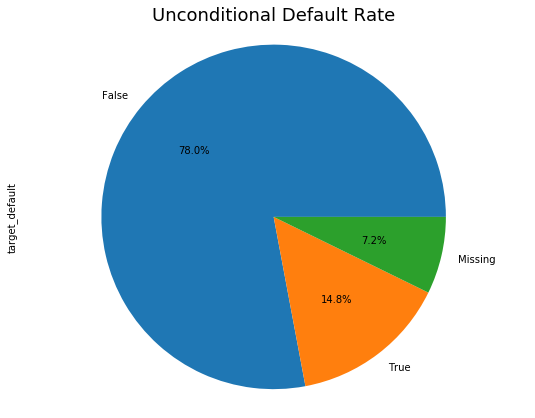

In [21]:
default = acquisition_train['target_default']
default = default.fillna('Missing')
default = default.value_counts()/default.shape[0]
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
default.plot(kind='pie', autopct='%1.1f%%', ax=ax)
ax.axis('equal')
_ = ax.set_title('Unconditional Default Rate', fontdict={'fontsize':18})

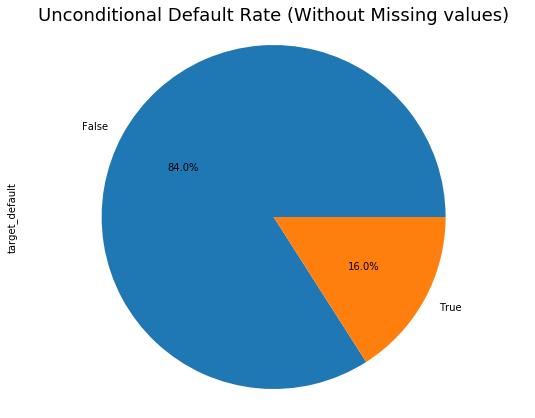

In [22]:
default = acquisition_train['target_default'].dropna()
default = default.value_counts()/default.shape[0]
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
default.plot(kind='pie', autopct='%1.1f%%', ax=ax)
ax.axis('equal')
_ = ax.set_title('Unconditional Default Rate (Without Missing values)', fontdict={'fontsize':18})

**Resposta 1: Nós temos uma probabilidade incondicional de 16.0% de um cliente se tornar inadimplente**  
Dessa forma, sem considerar nenhuma variável, nós podemos criar um Modelo-Nulo que prediz 16% de chance de inadimplência de qualquer cliente. O importante aqui é notar que nós teremos de lidar com o problema de desbalanceamento de classes (*class imbalance*) em nosso modelo de classificação.  
Antes de iniciarmos a análise de distribuições condicionais da taxa de inadimplência, vamos observar a relação entre os *scores* de crédito e a taxa de inadimplência

## Scatter dos Scores de Crédito <a name="02-score-scatter"></a>
Vamos *plotar* os *scatters* das variáveis de score de crédito. Nós buscamos, aqui, encontrar padrões de interdependência entre cada *score*, e entre os *scores* e a taxa de inadimplência.

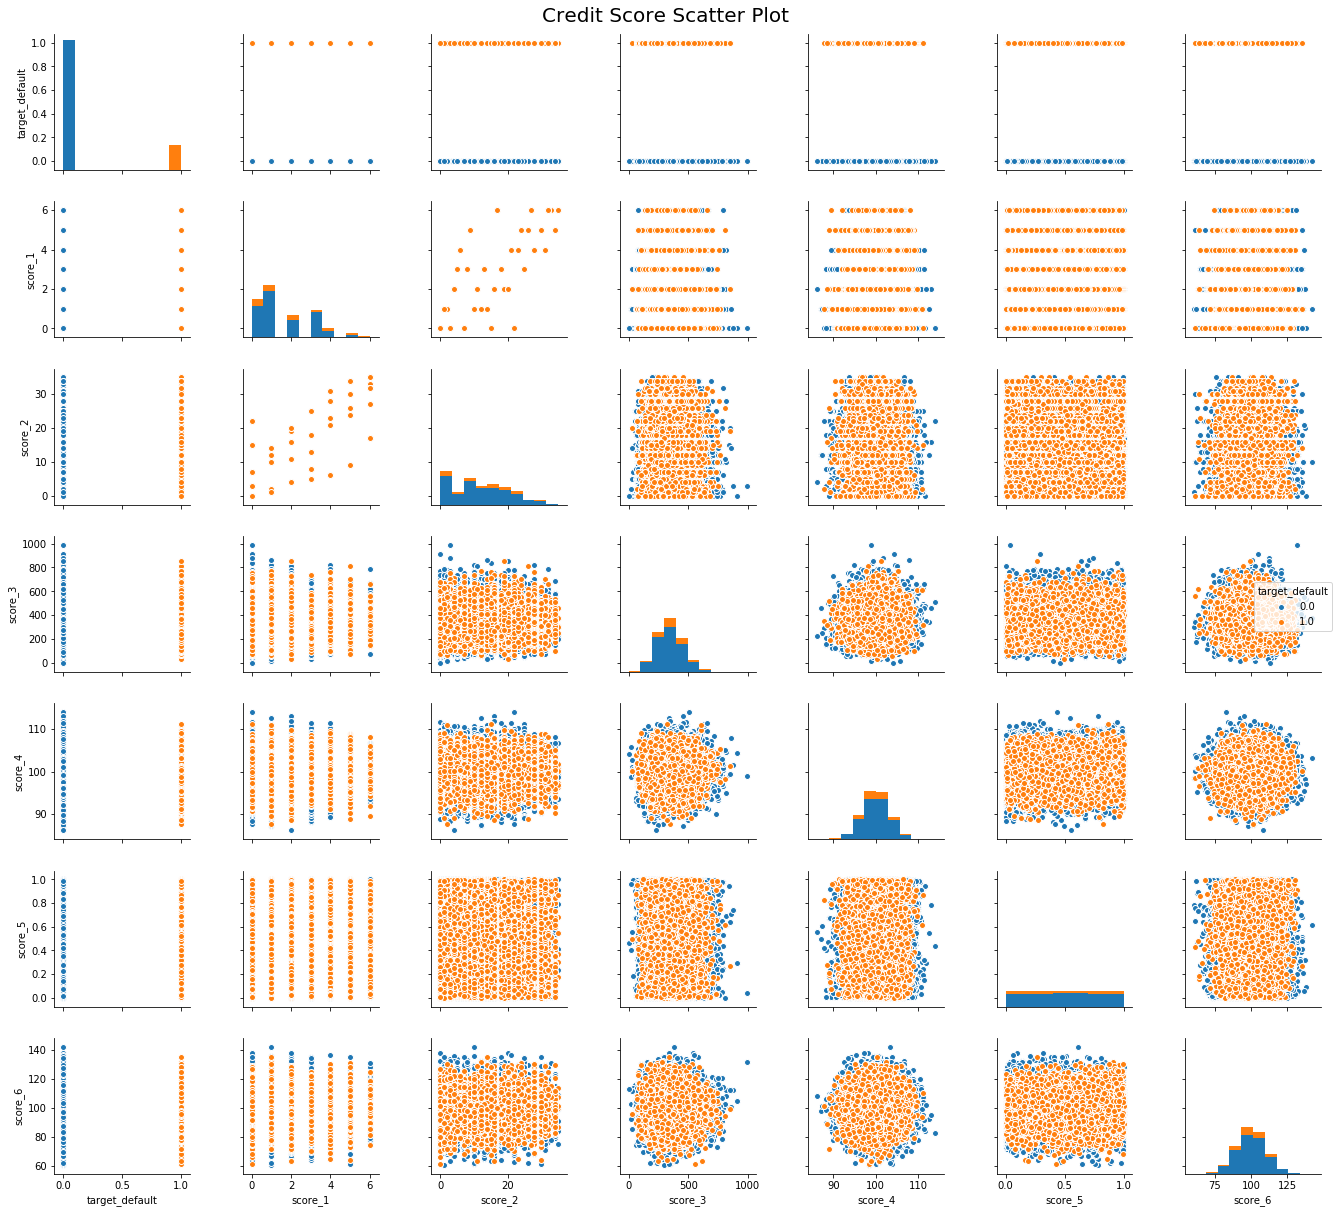

In [23]:
scores_df = acquisition_train[['target_default','score_1','score_2','score_3','score_4','score_5','score_6']].dropna(how='any').astype(np.float32)
scatter = sns.pairplot(scores_df, hue='target_default', diag_kind='hist')
plt.suptitle('Credit Score Scatter Plot', fontsize=20)
plt.tight_layout(rect=[0, 0.02, 1, 0.97])

Os *scatters* acima nos mostram alguns pontos interessantes:  
**Resposta 2: Aparentemente, os scores de crédito podem discriminat a variável *target* nos seus valores extremos. Nós exploraremos essa possibilidade mais profundamente na etapa de modelagem.**  
**Resposta 3: Temos algumas pistas de que os *scores* contém informações complementares. Nós podemos identificar certos padrões de interação das variável e tentaremos usar algumas *features* baseadas nessas interações como $X.Y$ e $X^2+Y^2$.**

### Taxa de Inadimplência Condicionada à Variáveis Continuas <a name="02-dist-numerical"></a>
Nós iremos criar alguns histogramas da taxa de inadimplência condicionada às variáveis contínuas. Nos gráficos, o eixo Y indica a taxa de inadimplência entre as observações contidas em um grupo do eixo X. Assim, o valor do eixo Y é a proporção de clientes inadimplentes em um grupo de clientes definidos à partir da segmentação da variável contínua. O texto acima das barras indica o número total de observações (adimplentes e inadimplentes) naquele grupo. É importante observar esse valor pois grupos com poucas observações tendem a apresentar estatísticas com alta variância e são, portanto, pouco confiáveis.  
Idealmente, nós queremos encontrar padrões que discriminem a taxa de inadimplência através dos grupos.

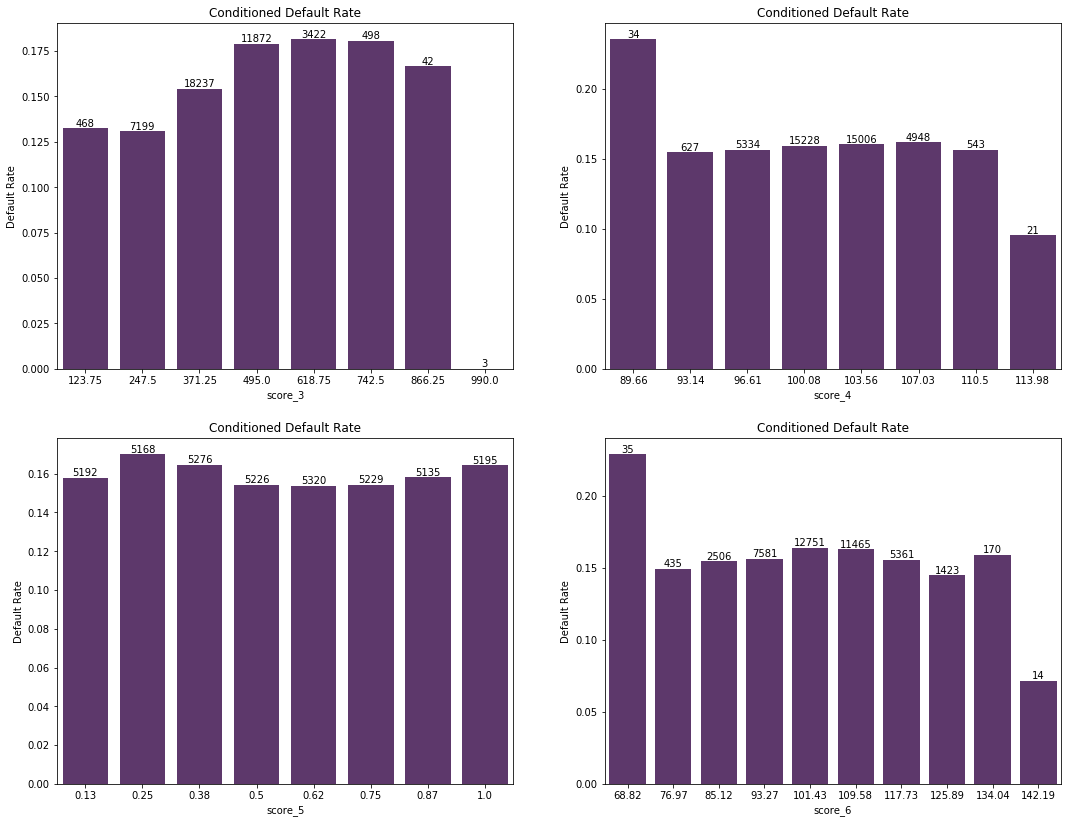

In [24]:
import src.data_viz as dv
target_col = 'target_default'

fig = plt.figure(figsize=(18,14))

col = 'score_3'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(221)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=8, ax=ax)
col = 'score_4'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(222)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=8, ax=ax)
col = 'score_5'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(223)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=8, ax=ax)
col = 'score_6'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(224)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=10, ax=ax)

Como vimos anteriormente, os scores tendem a discrminar a variável target em seus valores extremos. O "porém" que identificamos aqui é que essa região possui poucos dados e, por isso, não pode ser considerada confiável.
O melhor padrão é encontrado no gráfico do `score_3`. Nele vemos que clientes com um menor *score* aprensentam uma menor taxa relativa de inadimplência (aproximadamente 12.5% no primeiro grupo).  
Os outros scores não apresentaram padrão muito claro de sicriminação. Resumimos com as seguintes opbservações:
1. `core_3` mostrou um poder discriminante nos grupos com menores valores e um padrão consistente (crescente) nos groupos
2. `score_4` ampenas discrimina o *target* nos valores extremos onde os groupos tem poucas observações (alta variância => pouco confiável)
3. `score_5` montra um pequena redução na probabilidade de inadimplência no centro da distribuição
3. `score_6` mostra um pequena redução na probabilidade de inadimplência nos da distribuição

   
**Obs. Mesmo com essas observações, nós não podemos assumir que as variáveis de *score* tenham, ou não, poder preditivo. Nosso EDA será usado como guia pra construção e utilização de variáveis e não como palavra final sobre elas**

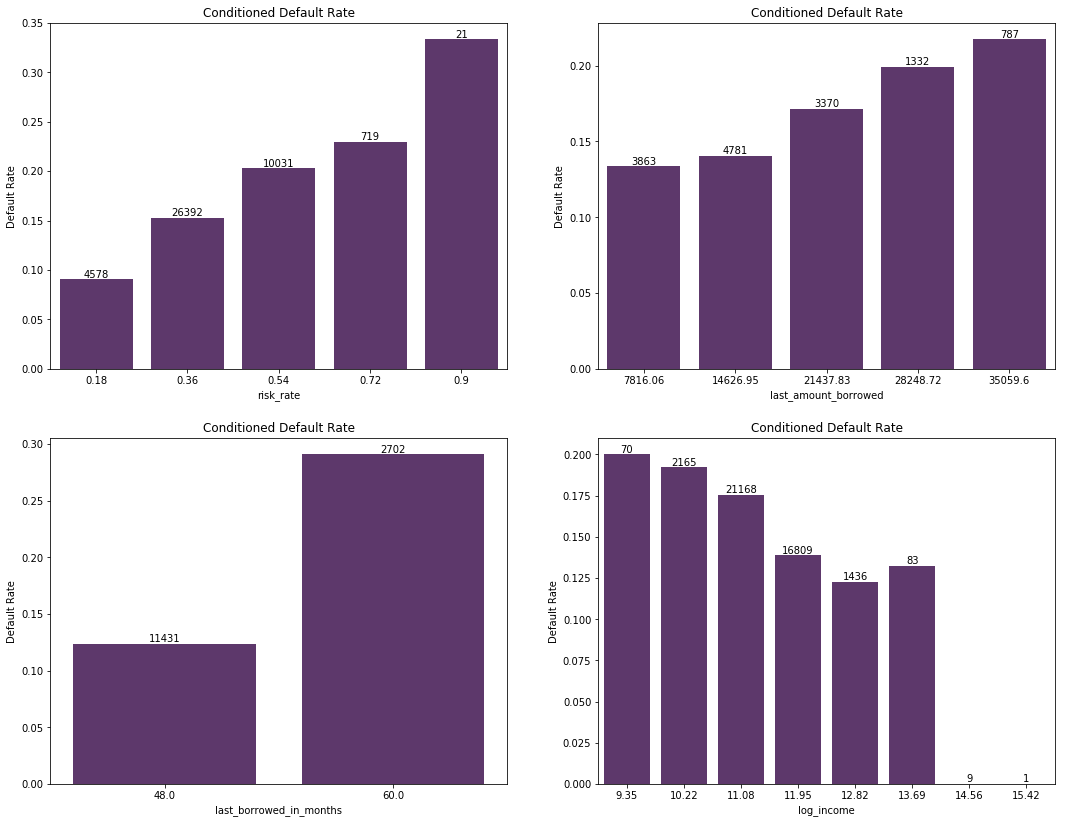

In [25]:
fig = plt.figure(figsize=(18,14))
col = 'risk_rate'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(221)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=5, ax=ax)
col = 'last_amount_borrowed'
ax = fig.add_subplot(222)
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=5, ax=ax)
col = 'last_borrowed_in_months'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(223)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=5, ax=ax)
col = 'income'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any').replace(np.inf,0)
cleaned_data['log_income'] = np.log1p(cleaned_data[col])
ax = fig.add_subplot(224)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition='log_income', variable_name='Default', max_bins=8, ax=ax)

Nós podemos fazer as seguintes observações sobre os histogramas acima:
1. `risk_rate`: tem um claro padrão discriminativo. Quanto maior o valor de `risk_rate`, maior a probabilidade de um cliente se tornar inadimplente. Embora o último grupo tenha poucas observações, o padrão consistente dessa variável nos deixa confortável com sua estatística. Vemos aqui que o modelo utilizado para a produção dessa variável está fazendo um bom trabalho!
- `last_amount_borrowed` tambpem mostrou um padrão claro. Clientes que emprestaram uma grande quantia financeira tem uma maior probabilidade de se tornar inadimplente.
- `last_borrowed_in_month` mostrou que empréstimos de longo prazo predizem uma maior chance de inadimplência.
- `income` mostrou que clientes com uma maior renda exibem uma chance reduzida de se tornarem inadimplente. O padrão é bem claro nessa variável.

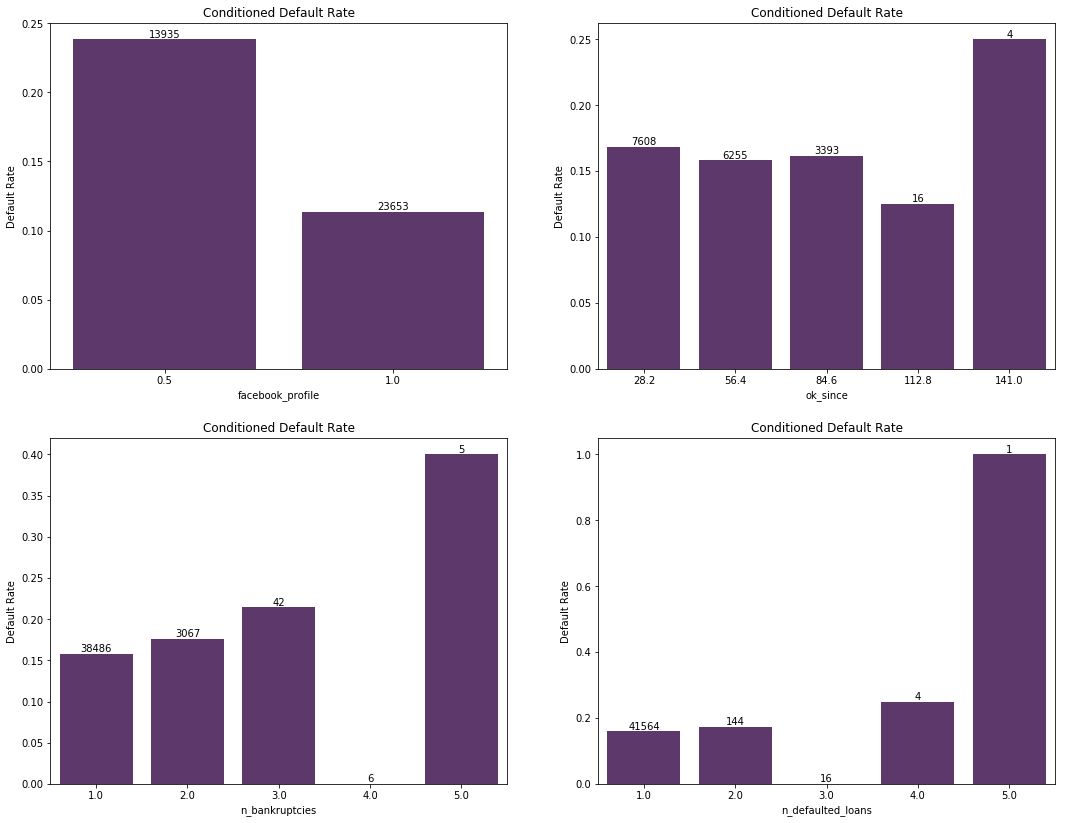

In [26]:
fig = plt.figure(figsize=(18,14))
col = 'facebook_profile'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(221)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=5, ax=ax)
col = 'ok_since'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(222)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=5, ax=ax)
col = 'n_bankruptcies'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(223)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=5, ax=ax)
col = 'n_defaulted_loans'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(224)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=6, ax=ax)

Nos gráficos acima, a principal observação diz respeito à variável `facebook_profile`. O gráfico mostra que, curiosamente, clientes sem perfil na rede social tem uma consideravelmente maior probabilidade de se tornar inadimplentes, quando comparado com os cliente que possuem perfil.

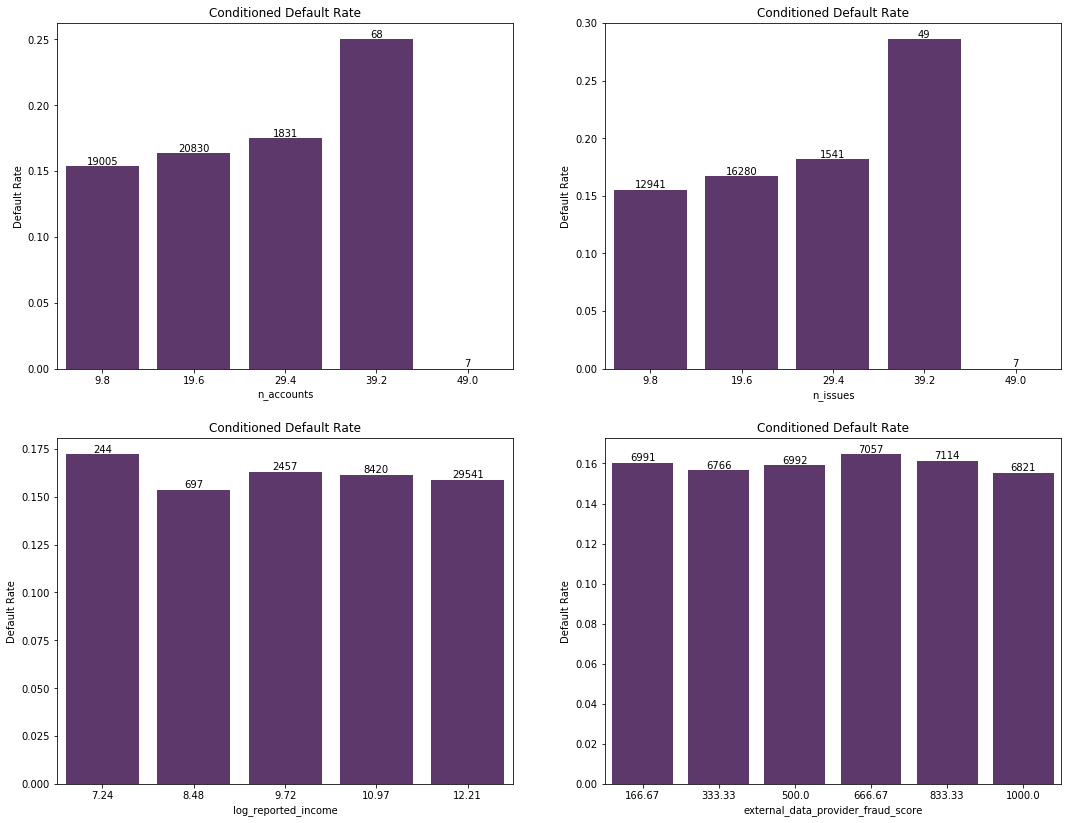

In [27]:
fig = plt.figure(figsize=(18,14))
col = 'n_accounts'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(221)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=5, ax=ax)
col = 'n_issues'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(222)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=5, ax=ax)
col = 'reported_income'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
cleaned_data['log_reported_income'] = np.log1p(cleaned_data[col])
ax = fig.add_subplot(223)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition='log_reported_income', variable_name='Default', max_bins=5, ax=ax)
col = 'external_data_provider_fraud_score'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(224)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=6, ax=ax)

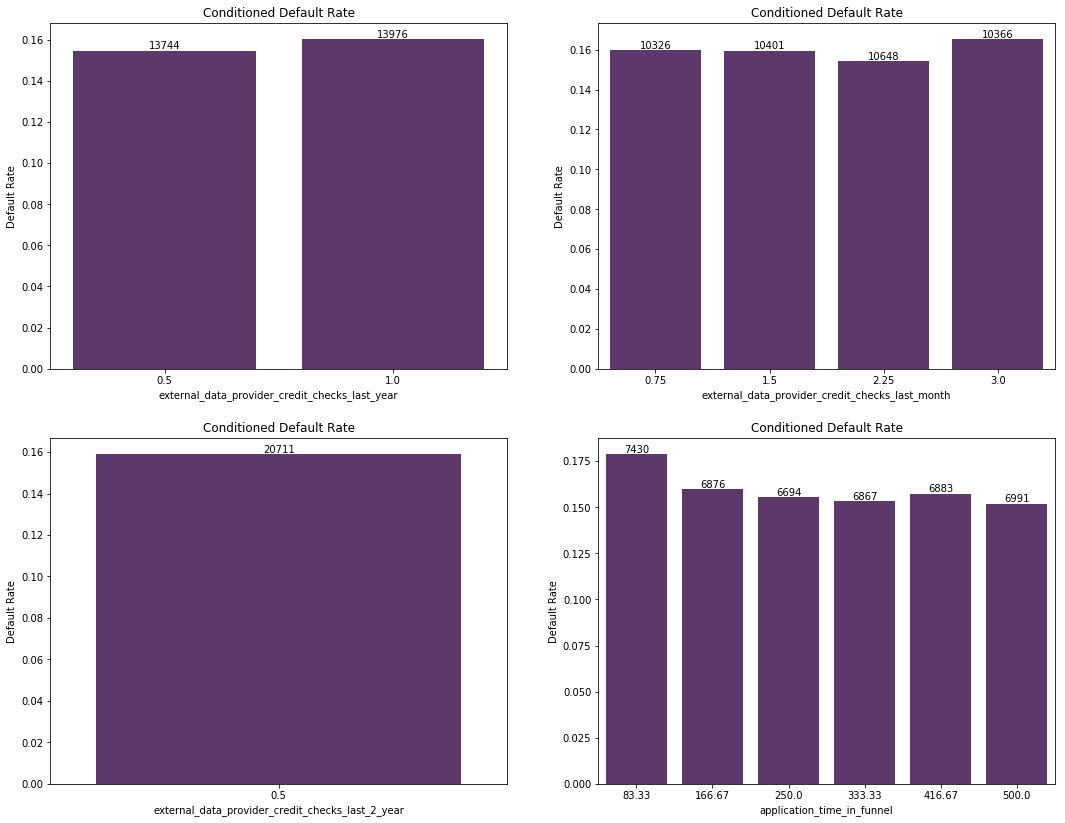

In [28]:
fig = plt.figure(figsize=(18,14))
col = 'external_data_provider_credit_checks_last_year'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(221)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=5, ax=ax)
col = 'external_data_provider_credit_checks_last_month'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(222)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=5, ax=ax)
col = 'external_data_provider_credit_checks_last_2_year'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(223)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=5, ax=ax)
#col = 'application_time_in_funnel'
col = 'application_time_in_funnel'
cleaned_data = acquisition_train[[target_col,col]].dropna(how='any')
ax = fig.add_subplot(224)
dv.plot_continuous_conditioned_variable(cleaned_data, variable=target_col, condition=col, variable_name='Default', max_bins=6, ax=ax)

Todos as análises univariadas das distribuições que foram apresentadas nos dão um ponto de partida para iniciar a construção de um modelo. Embora essas interações no espaço de grande simensionalidade das *features* mude as relações com a variável *target*, nós podemos iniciar a contrução do modelo com as variáveis que se mostraram mais promissoras na análise univariada e ir adicionando, ou removendo, novas *features* conforme nossa estratégia de validação for permitindo.

### Variáveis Geográficas <a name="02-geo-dist"></a>
O conjunto de dados possui um grupo relevante de variáveis com interpretação geográfica como, por exemplo, `lat_lon`, `zip`, `state`, etc.
Acreditamos que esse conjunto terá grande importância nos três problemas que serão atacados. Aqui, nós daremos um exemplo da variável target segmentada em quadrantes de latitude e longitude e, antecipando a seção de *feature engineering*, mostraremos como criamos uma nova varíavel baseada, também, em latitude e longitude.
Vamos começar segmentando o espaço da variável `lat_lon` e agregando os casos de inadimplência nos quadrantes. Abaixo, utilizamos um *heat map* para visualizar esses dados:

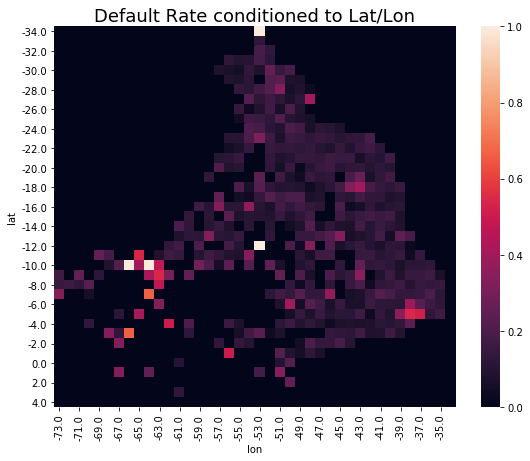

In [29]:
lat_lon = acquisition_train[['target_default','lat','lon']].copy()
lat_lon[['lat','lon']]=lat_lon[['lat','lon']].round()
lat_lon_default = lat_lon.groupby(['lat','lon']).sum().reset_index()
lat_lon_all = lat_lon.groupby(['lat','lon'])['target_default'].apply(lambda x: np.sum(x.isnull()==False)).reset_index().rename(columns={'target_default':'total'})
lat_lon = lat_lon_all.merge(lat_lon_default, how='left', on=['lat','lon']).rename(columns={'target_default':'default'})
lat_lon['perc'] = lat_lon['default'].div(lat_lon['total'].replace(0,1), fill_value=0)
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
sns.heatmap(lat_lon.pivot(index='lat',columns='lon', values='perc').fillna(0).astype(np.float32), ax=ax)
_ = ax.set_title('Default Rate conditioned to Lat/Lon', fontdict={'fontsize':18})

As regiões mais claras mostram as regiões com maior incidência percentual de casos de inadimplência. A variável `state` está obfuscada e, por isso, não permite uma análise análoga. Em vista disso, apesar de termos a variável aberta `shipping_state` que tem outra semântica, queremos estimar o estado de origem à partir das variáveis de latitude e longitude. Cumprimos esse objetivo com o pacote `reverse_geocoder`, deponível para Python, que nos retorno uma localidade à partir das coordenadas geográficas.
Abaixo verificamos a incidência de casos de inadimplência segregados nessa nova variável, chamada `estimated_state`:

In [30]:
display(acquisition_train_original[['estimated_state','target_default']].groupby('estimated_state').sum().sort_values('target_default', ascending=False).head())

,target_default
estimated_state,
BR-CE,878
BR-RN,727
BR-MG,716
BR-SP,553
BR-RO,444


Apesar da dificuldade de visualização, os casos de maior incidência de inadimplência paracem coincidir com o *heat map*. 
Passemos, agora, a avaliar as métricas do modelo e como elas se relacionam com a performance do negócio.

# Metricas <a name="02-metrics"></a>
NUma etapa posterior, teremos que avaliar o impacto do nosso modelo na performance do Nubank. Por isso, é importante encontrar métricas que funcionem como um * proxy* para as métricas do negócio, isso é, nós queremos métricas estatísticas intimamente relacionadas com métricas que representem a performance do negócio. 
Nós começaremos elaborando algumas questões:
1. **Nós podemos estimar o valor esperado do valor financeiro de um cliente adimplente ? **
2. **Nós podemos estimar o prejuízo esperado de um cliente inadimplente ?**
3. **Qual é o *trade-off* entre incorretamente aceitar um cliente inadimplente e ou rejeitar um cliente adimplente ?**

### Estimando o lucro e prejuízo (P&L) esperado dos clientes adimplentes e inadimplentes

Embora não estejamos utilizando `spend_train` na modelagem de risco de créditos, nós vamos utilizar essa base para estimar o valor financeiro esperado dos clientes e, com isso, obter uma melhor interpretação das métricas estatísicas utilizadas.  
Queremos estimar a variável aleatória *Profit and Loss* que indica o lucro ou prejuízo que determinado cliente trará ao banco.  
Nós estimaremos a distribuição dessa variável condicionada aos grupos de clientes adimplentes e inadimplentes. Com isso, nós poderemos avaliar o *trade-off* entre incorretamente aceitar um cliente inadimplente e rejeitar um cliente adimplente.  
As seguintes informações foram fornecidas:
1. Juros rotativo mensal: 17%
2. Taxa de intercâmbio: 5%
3. Custo de emissão de cartão de crédito: R\$10,00
4. Custo de SAC por minuto: R\$2,50
5. Taxa mensal de inflação: 0.5%
   
Observações:  
1. **Nós iremos ignorar a taxa de custo de oportunidade do capital (CDI) e considerar a taxa mensal do rotativo como o *spread* total de lucro do banco.**<BR>
2. **Nós iremos considerar o prejuízo causado por um cliente inadimplente como seu último gasto mensal mais o valor ajustado do rotativo (como afirmado no guia do projeto)**
3. **Os valores mensais da fatura e rotativo já estão sendo ajustados para inflação na função de carregamento de dados**


In [33]:
credit_card_spread = 0.17
inflation_rate = 0.005
interchange_fee = 0.05
credit_card_cost = -10
cas_cost = -2.5

raw_acquisition_train, spend_train = du.load_data_preprocessed('../data')

# Ensure the data is ordered to get the correct 'last month default loss'
spend_train = spend_train.sort_values(['ids','month'])

spend_train['profit_and_loss'] = spend_train['revolving_balance']*(credit_card_spread-interchange_fee) + spend_train['spends']*interchange_fee + spend_train['card_request']*credit_card_cost + spend_train['minutes_cs']*cas_cost
spend_train['potential_default'] = - spend_train['revolving_balance']*credit_card_spread - spend_train['spends']

applicant_pnl = spend_train.groupby('ids')['profit_and_loss'].sum().to_frame()
applicant_pnl['potential_default'] = spend_train.groupby('ids')['potential_default'].nth(-1)
applicant_pnl = applicant_pnl
applicant_pnl['target_default'] = raw_acquisition_train.set_index('ids')['target_default']

applicant_pnl.loc[applicant_pnl['target_default']==True,'profit_and_loss'] = applicant_pnl.loc[applicant_pnl['target_default']==True,'potential_default']
applicant_pnl = applicant_pnl[['profit_and_loss','target_default']]

profit_and_loss = applicant_pnl.loc[applicant_pnl['target_default']==False,'profit_and_loss'].apply(['min','max','mean','median','std','count']).to_frame('non_defaulting_pnl')
profit_and_loss['defaulting_pnl'] = applicant_pnl.loc[applicant_pnl['target_default']==True,'profit_and_loss'].apply(['min','max','mean','median','std','count']).to_frame('non_defaulting_pnl')
display(profit_and_loss.applymap('R$ {:,.2f}'.format))

,non_defaulting_pnl,defaulting_pnl
min,R$ -77.13,"R$ -22,267.20"
max,"R$ 28,126.31",R$ -0.00
mean,"R$ 4,659.41","R$ -2,909.89"
median,"R$ 3,484.84","R$ -1,625.36"
std,"R$ 3,999.41","R$ 3,498.21"
count,"R$ 35,080.00","R$ 6,661.00"


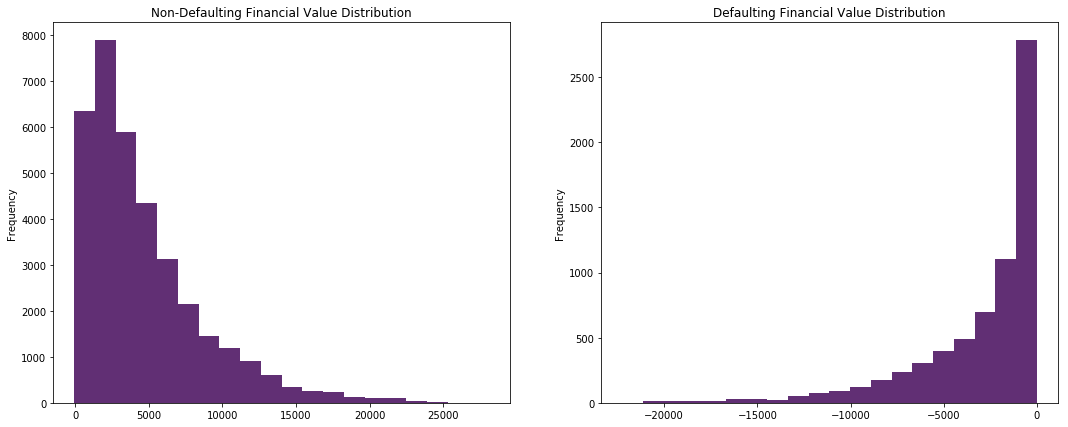

In [34]:
fig = plt.figure(figsize=(18,7))
main_color = (97/255, 47/255, 116/255, 1.)
ax = fig.add_subplot(121)
applicant_pnl.loc[applicant_pnl['target_default']==False,'profit_and_loss'].plot(kind='hist', bins=20, ax=ax, color=main_color, title='Non-Defaulting Financial Value Distribution')
ax = fig.add_subplot(122)
_ = applicant_pnl.loc[applicant_pnl['target_default']==True,'profit_and_loss'].plot(kind='hist', bins=20, ax=ax, color=main_color, title='Defaulting Financial Value Distribution')

A tablea acima mostra os valores financeiros esperados para o negócio no caso de adimplência ou inadimplência. **Grosseiramente falando, dois clientes inadimplentes já são suficientes para, não apenas compensar o lucro de um cliente adimplente mas, também, incorrer em prejuízo para o Nubank.** Essá é uma afirmação forte, principalmente em face da diferença de distribuições e *skewness* das variáveis mas, para efeito desse problema, consideraremos o caso médio como válido.  
O ponto principal é manter em mente que estamos equilibrando a os casos de inadimplência corretamente previstos (*True Positives*) com os casos incorretos de rejeição de clientes adimplentes (*False Negative*) e teremos de estar atentos a isso.  
Os istogramas acima nos mostram uma distribuição próxima de uma log-normal para os casos adimplentes e uma distribuição próxima a normal, com assimetria negativa (e possívelmente leptokurtica), para os casos de inadimplência.  

Nesse ponto nós já podemos responder as três perguntas anteriores:
* **Resposta 1: O lucro esperado por um cliente adimplente é R\$ 4,659.41**
* **Resposta 2: O prejuízo esperado por um cliente inadimplente é R\$ -2,879.58**
* **Resposta 3: O prejuízo de dois clientes inadimplentes já é suficiente para compensar o lucro de um cliente adimplente e trazer prejuízo**

### Relação entre Valores Financeiros e Métricas Estatísticas
Nesse ponto, nós já podemos ver a importancia da precisão (*precision*) neste problema. Nós queremos minimizar os falsos positivos do modelo mas isso também pode significar rejeitar um cliente que traria lucro ao Nubank.
**Dessa forma, o *F-beta score* com baixo valor de *beta* será uma métrica adequada que concorda com as condições de negócio.**

Para ilustrar a relação de impacto financeiro e métricas estatísticas, construiremos um exemplo utilizando os valores estimados para ilutrar com o que estamos lidando:    

In [35]:
data_size = 500
ground_truth = np.zeros((data_size,))
defaulted = np.random.permutation(data_size)[:int(0.16*data_size)]
ground_truth[defaulted] = 1
toy_example = pd.DataFrame(ground_truth, columns=['ground_truth'])
toy_example['all_false'] = np.zeros((data_size,))
toy_example['all_positive'] = np.ones((data_size,))
toy_example['random_guess'] = np.random.randint(0,2,size=(data_size,))
half_true = np.zeros((data_size,))
half_true[defaulted[:int(data_size*0.1)]] =1
toy_example['half_true'] = half_true

from sklearn.metrics import accuracy_score, roc_auc_score, fbeta_score
metrics = toy_example.apply(lambda x: accuracy_score(toy_example['ground_truth'],x)).to_frame(name='accuracy')
metrics['roc_auc'] = toy_example.apply(lambda x: roc_auc_score(toy_example['ground_truth'],x))
metrics['f-0.25'] = toy_example.apply(lambda x: fbeta_score(toy_example['ground_truth'],x, 0.25))
metrics['f-2.0'] = toy_example.apply(lambda x: fbeta_score(toy_example['ground_truth'],x, 2.0))
metrics['financial_value'] = toy_example.apply(lambda x: np.sum((toy_example['ground_truth']==0)&(x==0))*4659.41-np.sum((toy_example['ground_truth']==1)&(x==0))*1160.98)
display(metrics)

,accuracy,roc_auc,f-0.25,f-2.0,financial_value
ground_truth,1.00,1.000000,1.000000,1.000000,1956952.20
all_false,0.84,0.500000,0.000000,0.000000,1864073.80
all_positive,0.16,0.500000,0.168317,0.487805,0.00
random_guess,0.47,0.502381,0.168165,0.370995,848152.03
half_true,0.94,0.812500,0.965909,0.675676,1922122.80


A tabela acima mostra a relação entre algumas métricas e o valor financeiro, alcançado pelo negócio, em alguns experimentos simulados.
A linha `ground_truth` representa a variável *target* simulada e, por isso, tem precisão de 100%. As próximas duas linhas mostram o efeito de um modelo que retorna uma constante como previsão: falso na primeira, e verdadeira na segunda. A linha `random_guess` é uma variável aleatória uniforme e `half_true` é um modelo que acerta 50% das classes positivas.
Nós podemos ver que a métrica que melhor representa o impacto financeiro é a f-025. **Em nosso modelo, nós utilizaremos a métrica *F-0.25 score*, *accuracy* e *AUC ROC* como métricas mas apenas a F-0.25 será utilizada para seleção de modelo.** As outras métricas serão monitoradas para nos guiar no processo de modelagem.

# *Feature Engineering* <a name="02-feat-eng"></a>

A principal proposta desta seção é prover uma breve indicação de algumas variáveis vriadas e utilizadas no modelo. Nós não iremos nos aprofundar na discussão ou apresentar gráficos pois isto está além do escopo, e do prazo, do projeto. A importância das variáveis criadas fica claro no procedimento de seleção (*feature selection*) e nos gráficos de importância de variáveis (*plot importance*)

### *Agreggating Features*
A principal classe de modelos utilizada nos problemas será a baseada em árvores de decisão. Um tipo de variável artifical (criada) que costuma performar bem nessa classe de modelos são aquelas baseadas em agregação. Elas são criadas agregando alguma variável em um conjunto de outras variáveis. Assim, por exemplo, temos as variáveis `income` e `state`. Podemos criar uma variável que indica a renda média (`income`) condicionada a cada estado (`state`). Podemos ir além e calcular o Z-score da renda em relação à média e desvio padrão da renda no estado do cliente.  
Essa variáveis são interessantes pois podemos incluir agregações semanticamente válidas enquanto nos permite manter um pequeno tamanho médio das árvores de decisão e, assim, mitigar o problema de *overfitting*

### Excesso de valores únicos das variáveis Shipping_Zip_Code and Profile_Phone_Number
Na etapa de *Data Cleaning*, nós verificamos que algumas variáveis possuem uma grande quantidade de valores únicos (na ordem de grandeza da quantidade de linhas da base de dados). As variáveis `shipping_zip_code`, por exemplo, possui 28263 valores enquanto `profile_phone_number` possui 45000. Esse tipo de granularidade dos dados torna seu uso inviável e por isso, nós temos que reduzi-los. Nós utilizamos os 3 primeiro números de cada variável para construie novas *features*. A ideia é manter uma interpretação geográfica mais abrangente e, por isso, com menos valores.

### Variáveis baseadas no nome do cliente
Nós testamos algumas variáveis baseadas nos nomes presentes em `external_data provider_first_name`. Nós terminamos com 3 novas *features* baseadas na original. A primeira é, simplesmente, o tamanho do nome do cliente. Na segunda, nós testamos se a última letra do nome é igual a "a". A ideia seria ter um proxy do gênero do cliente.
Por fim, nós conseguimos uma base parcial de nomes do Censo 2010 em formato da linguagem R. Nós convertemos para DataFrame e criamos uma função para estimar o gênero do cliente com mais precisão (função `data_util.estimate_is_female`)

### Variáveis geográficas
Nós já vimos que foram criadas algumas variáveis baseadas em latitude e longitude. De fato, foram criadas duas variáveis: `estimated_state` e `estimated_district` através do já citado pacote reverce_geocoder. Essas variáveis se mostraram complementar com as original `state` e `shipping_state`.

# Modelagem <a name="02-modeling"></a>
Nesta seção, descreveremos o modelo usados, o procedimento de treinamente e os resultados obtidos. Nós começamos por responder de forma concisa e objetiva o questionário pedido na seção **Tarefas** no Projeto Nubank, no portal da Udacity. Em seguida, seguiremos com uma análise mais profunda:

- **O que se está tentando prever?**  
Estamos prevendo a possibilidade de um cliente, no momento da solicitação de cartão de crédito, vir a se tornar inadimplente no futuro. Nosso modelo não está retornando a probabilidade (variável contínua entre zero e um) da inadimplência mas sim um valor binário sinalizando o evento.

- **Qual foi o target (variável alvo) escolhido? Se optou-se por um modelo não supervisionado, qual o motivo?**  
A variável alvo utilizada foi fornecida na própria base de dados, sob o nome de `target_default`. Ela é uma variável binária que indica a ocorrência de inadimplência.

- **Quais variáveis foram selecionadas e qual foi o critério de seleção?**  
O critério de seleção de variáveis se dá, primeiro pela indicação de importância que os modelos baseados em àrvores de decisão possuem. Segundo, pelo monitoramente das métricas em experimentos com validação cruzada (*cross-validation*). A lista completa das variáveis selecionadas é apresentada à seguir.

- **Quais as variáveis mais importantes do seu modelo?**  
As variáveis que mostraram maior importância foram as com significado geográfico: `state`, `zip`, `shipping_zip_code` e variáveis criadas baseadas em geografia.
(Uma lista de variáveis e importância nos modelos pode ser obtida no documento `feature_engineering_guide.md`

- **Quais métricas foram selecionadas para a validação do modelo? O que cada uma delas significa de acordo com o contexto do que se está tentando prever? Quais evidências te fariam crer ou não de que a performance de validação será a mesma de quando este modelo estiver rodando de fato com novos dados?**  
Como discutido na seção **Métricas**, nós utilziamos como métrica principal o *F-0.25 score*. A relação dela com as condições do negócio podem ser consultada na seção já mencionada. Também utilizamos a métrica *accuracy*, que possui alta interpretabilidade e que pode ser compara com a precisão de um Model-Nulo que, no nosso caso, possui 84% de precisão. Por fim, utilizamos a métrica *AUC ROC* como uma espécie de distância do chute completamente aleatório. Durante o processo de treinamento, nós tivemos o cuidado de fazer do modelo um caso repodutível e confiável. Nós usamos validação cruzada estratificada para a seleção de variáveis e para estimar a performance do modelo. Além disso, em todas as transformações dos dados de entradas, nós nos preocupamos em evitar vazamento de dados (*data leakage*) e separamos uma fração de dados que se manteve intocada durante o processo de treinamente e foi usada ao final para termos uma validação de todo o processo.


## O Modelo
Nós construímos um *framework* para realização de experimentos de *machine learning* fortemente baseado no paradigmo utilizado pelo *scikit_learn*. Dessa forma, pudermos testar variados modelos daquele pacote sem nenhum esforço além do de configurar os hiperparâmetros. Apesar disso, acamos por utilizar um modelo externo à bilbioteca, o LighGBM, mantido pela *Microsoft*.  
Esse modelo é largamente utilizado na modelagem de uma ampla classe de problema e, aqui, se mostrou superior às opções testadas do *scikit-learn*. O LightGBM siginifica, literalmente, *Light Gradient Boosting Machine*. Ele é uma *framework* para utilização de *ensemble* de árvores de decisão guiados por *gradient boosting*. Dessa forma, o estado final do modelo se caracteriza por um conjunto de árvores de decisão, potencialmente com milhares delas. Seus parâmetros de configuração permitem uma série de configurações avançadas para um treinamento robusto, como *bootstrapping*, regularizações, *bining* de variáveis, amostragem de *features*, entre outros.
O lightgbm tem uma tendência de *ovefitting* e por isso a fase de *tuning* dos hiperparâmetros foi importante. Nesta etapa, o conhecemento do comportamento dos parâmetros também é muito importante pois, devido ao grande número de parâmetros e valores aceitos, é impraticável realizar um *grid-search* de amplot espectro. Nossa abordagem foi realizar o acerto grosseiro baseado no conhecimento dos parâmetros e realizar o ajuste fino via *grid-search * com validação cruzada.  
No problema atual, nós utilizamos uma configuração para classificação binária. Utilizando a função de entropia cruzada, o modelo crias as árvores de decisão e estima o resultado, nas folhas, através de contagem de votos das amostras classificadas.
 

## Validação Cruzada
Validação cruzada é sempre um tema sensível em *machine learning*. As pontos que vamos discutir aqui dizem respeito ao número de divisões nos dados, estratégia de divisão e vazamento de dados.
Utilizamos uma validação cruzada com conjuntos (*5-Fold Cross Validation*). Um impeditivo de utilizar um número maior foi o forte *class imbalance* encontrado nesse problema. Muitos conjuntos na validação cruzada levaria o conjunto de validação a apresentar poucas observações positivas. *Class imabalance* também foi determinante na escolha da estratégia de divisão dos dados. Utilizamos uma validação cruzada estratificada, onde a distribuição das classes positivas é mantida em toda partição. Isso mitigou o efeito de *folds* com poucas observações positivas em relação aos outros.  
Por fim, a questão de vazamento de dados foi resolvida com o uso de uma arquitetura adequada para o *framework* de experimentação. Nosso *framework* trabalha em duas fases: *fit* e *trasform*. Na primeira, podemos utilizas os dados como bem entendermos pois só teremos acessos aos dados de treinamento. Na segunda etapa, dados de validação poderam estar presentes, então só poderemos realizar transformações em uma única observação ou utilizar estatísticas coletadas na etapa anterior.

## *Missing Values*
Outra característica interessante desse modelo é que ele aceita a entrada de dados com valores faltantes (NaN). Na prática o que acontece é que ele trata esses valores como uma classes distinta (no case de uma variável categórica) ou um valor distinto (no caso de uma variável contínua). Embora essa característica seja muito apreciada, em nosso pipeline nós implementamos utilizamos um módulo de para preenchimento de valores faltantes. Quatro estratégias são possíveis:
1. `constant`: Assim como no lightgbm, esse método preenche os dados faltantes com um valor distinto dos presentes nos dados
2. `mean`: Preenche os dados faltantes contínuos com a média dos dados existentes
3. `median`: Preenche os dados faltantes contínuos com a mediana dos dados existentes
4. `most_frequent`: Preenche os dados faltantes categóricos com a categoria mais frequente
No nosso problema, a estratégia `constant` apresentou melhor performance validada em `cross-validation`

## Parâmetros e Seleção de Variáveis
Os principais parâmetros utilizados e seus valores foram:
- learning_rate: 0.004
- n_estimators: 10000
- max_depth: 7
- num_leaves: 8
- max_bin: 512
- subsample: 0.9
- subsample_freq: 1
- colsample_bytree: 0.1
- min_data_in_leaf: 50
- verbose: 1
- categorical_feature: [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
- early_stopping_rounds: 1000
- scale_pos_weight: 1.5
- seed: 1234
- min_data_per_group: 250
- max_cat_threshold: 512
        
Não entraremos na desnecessária descrição e explicação dos parâmetros pois isso só tornaria essa seção tediosa. O único ponto a acrescentar diz respeito ao parâmetro `categorical_feature` que indica a posição das variáveis categóricas em nossa matriz de dados de entrada. Aqui, notamos que utilizamos um total de 24 variáveis categóricas.  
Como dito anteriormente, nosso processo de seleção de variáveis utilizou dois elementos. O primeiro foi o teste de performance, observando-se as métricas, em experimentos com validação cruzada. O segundo foi a utilização de gráficos de importância de variáveis, tradicionalmente disponíveis em modelos baseados em árvores de decisão.
Todas as variáveis e sua importância para o modelo podem ser vistas abaixo. A descrição detalhada delas pode ser encontrada no documento `feature_engineering_guide.md`

<img src="images/importances_credit_risk.png" width=800 height=900>

## Resultados
Nesta seção discutiremos os resultados do modelos. Todos os dados desta seção dizem respeito ao conjunto de validação que foi previamente separado e não foi utilizado no treinamento.
Iniciaremos apresentando a proporção de casos de inadimplência identificados pelo modelo:

<img src="images/target_pie_credit_risk.png" width=1200 height=1400>

Verificamos que o modelo final identificou cerca de 5.2% das amostras como casos de inadimplência. Vamos, agora, observar a matriz de confusão do classificador para conhecer a proporção de Falsos Positivos e Positivos Verdadeiros (duas estatísticas que nos interessam profundamente, conforme discutido anteriormente)

<img src="images/confusion_matrix_credit_risk.png" width=800 height=900>

Verificamos que o modelo deixa passar muitos casos de inadimplência mas, estamos interessados na relação Positivos Verdadeiros / Falsos Positivos. Note que aqui, temos essa relação com valor de 144/74 ~= 1.95. Lembremos da seção em que análisamos as métricas do modelo. Nós estimamos um lucro médio de R\$ 4,659.41, para os clientes adimplentes e um prejuízo médio de R\$ -2,879.58 para os clientes inadimplentes. Considerando-se correta a propoção da matriz de confusão, teríamos um impacto financeiro positivo de R\$ 69,863.18 em relação ao Modelo-Nulo que, ingenuamente, aceita toda solicitação de cartão de crédito.  
Apesar de não termos alcançado uma performance entusiasmante, esses valores mostram que temos um modelo descente para um início de modelagem. Novas abordagens e explorações dos dados mais profundas ainda são necessária antes de podermos sugerir a utilização do modelo como opção prática de identificação de inadimplência.

Por fim, apresentamos as métricas de performance obtidas nos dados de validação:

In [36]:
metrics_df = pd.DataFrame(np.atleast_2d([0.86012,0.599583,0.591019]), columns=['Accuracy', 'AUC ROC', 'F-0.25'], index=['Credit_Risk'])
display(metrics_df)

,Accuracy,AUC ROC,F-0.25
Credit_Risk,0.86012,0.599583,0.591019


Conseguimos alguma melhora na precisão desse modelo. A distribuição natural dos dados apresenta forte desbalanceamento e já sai com precisão de 84% enquanto conseguimos  melhorar esse valor para 86%. A métrica *AUC ROC*, os diz que tivemos algum progresso (mas não muito) em relação ao chute completamente aleatório que tem AUCROC de 50%. Nosso modelo apresentou aproximadamente 60%. A métrica *F-025* tem valor absoluto menos interpretável, mas foi de extrema utilizade na discriminação das várias configurações e variações dos modelos testados. Seu principal uso foi na comparação do valor relativo entre os modelos.